In [69]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import copulas as cp
import pyvinecopulib as pv
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
plt.style.use(['science', 'ggplot-ubs.mplstyle'])
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False

sns.set_context('talk')
plt.rcParams['figure.figsize'] = (12, 5)
palette = sns.color_palette(as_cmap=True)
fmt = 'svg'

DATA = "../../001_Data"
OUT = "../Outputs/Figs"
one_bushel_to_pounds = 60
one_short_ton_to_bushels = 42.08
one_short_ton_to_pounds = one_short_ton_to_bushels*one_bushel_to_pounds

def savefig(name):
    plt.savefig(os.path.join(OUT, f'{name}.{fmt}'))
sns.color_palette()

[(0.30196078431372547, 0.23529411764705882, 0.1843137254901961),
 (0.7529411764705882, 0.44313725490196076, 0.33725490196078434),
 (0.9098039215686274, 0.7803921568627451, 0.403921568627451),
 (0.6431372549019608, 0.21568627450980393, 0.1450980392156863),
 (0.8117647058823529, 0.7411764705882353, 0.6078431372549019),
 (0.6823529411764706, 0.6901960784313725, 0.7019607843137254),
 (0.9294117647058824, 0.8431372549019608, 0.615686274509804),
 (0.4823529411764706, 0.49019607843137253, 0.5019607843137255),
 (0.9019607843137255, 0.7137254901960784, 0.6431372549019608),
 (0.27450980392156865, 0.2784313725490196, 0.28627450980392155),
 (0.6313725490196078, 0.8, 0.8941176470588236),
 (0.0, 0.5372549019607843, 0.5529411764705883),
 (0.7254901960784313, 0.6980392156862745, 0.6392156862745098),
 (0.22745098039215686, 0.3411764705882353, 0.5411764705882353),
 (0.7529411764705882, 0.8196078431372549, 0.6078431372549019),
 (0.4823529411764706, 0.4196078431372549, 0.34901960784313724),
 (0.6862745098039216, 0.7372549019607844, 0.8352941176470589),
 (0.4588235294117647, 0.592156862745098, 0.19215686274509805),
 (0.8784313725490196, 0.8352941176470589, 0.7411764705882353),
 (0.21176470588235294, 0.5725490196078431, 0.792156862745098),
 (0.6509803921568628, 0.7450980392156863, 0.396078431372549),
 (0.4235294117647059, 0.5294117647058824, 0.7019607843137254),
 (0.7529411764705882, 0.6, 0.4745098039215686),
 (0.592156862745098, 0.8274509803921568, 0.8),
 (0.43529411764705883, 0.7137254901960784, 0.8745098039215686),
 (0.8745098039215686, 0.6784313725490196, 0.13333333333333333),
 (0.3333333333333333, 0.6941176470588235, 0.7058823529411765)]

In [2]:
soybean = pd.read_csv(os.path.join(DATA, 'Soybean.csv'), index_col='Date', parse_dates=True, dayfirst=True)
soybean_oil = pd.read_csv(os.path.join(DATA, 'SoybeanOil.csv'), index_col='Date', parse_dates=True, dayfirst=True)*100*0.11
soybean_meal = pd.read_csv(os.path.join(DATA, 'SoybeanMeal.csv'), index_col='Date', parse_dates=True, dayfirst=True)*0.022
data = soybean.join(soybean_oil, how='outer').join(soybean_meal, how='outer').ffill().resample('M').last().dropna().sort_index()
data.columns = ['Soybean', 'Soybean Oil', 'Soybean Meal']
data['Crush Spread'] = data['Soybean Meal'] + data['Soybean Oil'] - data['Soybean']

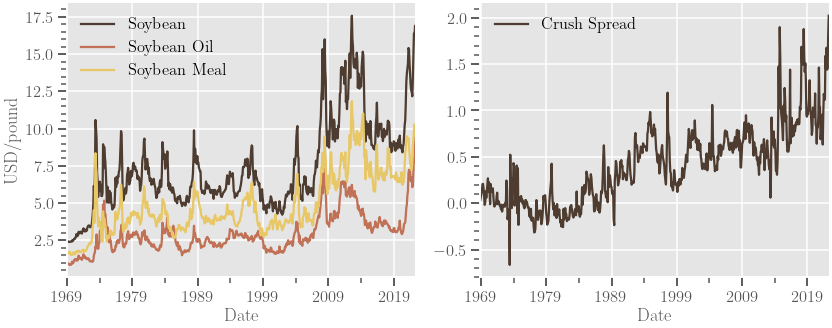

In [55]:
fig, ax = plt.subplots(1, 2)
data.drop(['Crush Spread'], axis = 1).plot(ax = ax[0])
data['Crush Spread'].plot(ax = ax[1], legend = True)
ax[0].set_ylabel('USD/pound')
plt.tight_layout()
savefig('Data')

In [4]:
data.tail()

,Soybean,Soybean Oil,Soybean Meal,Crush Spread
Date,,,,
2021-12-31,13.3715,6.2128,8.83564,1.67694
2022-01-31,14.9050,7.1302,9.21580,1.44100
2022-02-28,16.3825,7.9849,9.85644,1.45884
2022-03-31,16.1825,7.6934,10.28500,1.79590
2022-04-30,16.8945,9.3698,9.54668,2.02198


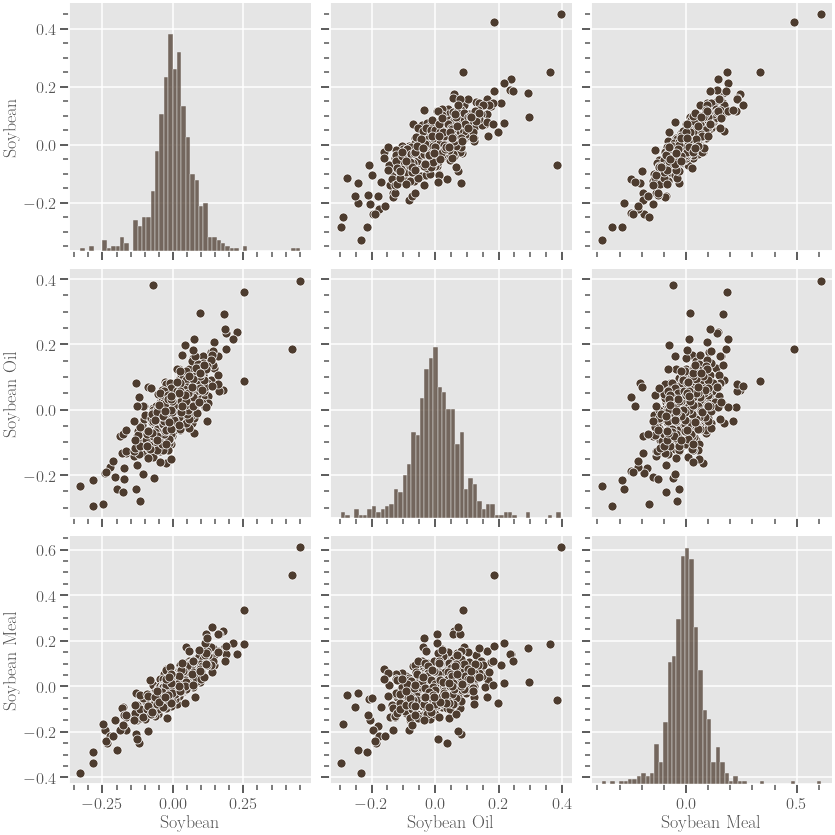

In [56]:
logrets_df = np.log(data.drop(['Crush Spread'], axis=1)).diff().dropna()
_ = sns.pairplot(logrets_df, height=4, aspect=1,
                 diag_kws = {'color': palette[0], 'bins': 50},
                 plot_kws = {'color': palette[0]})
savefig('PairPlot')

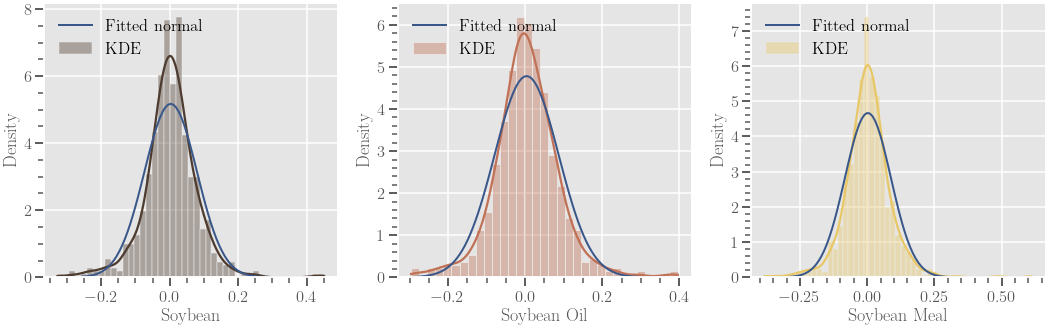

In [57]:
def plot_norm_fit(axes, data):
    xmin, xmax = data.min(), data.max()
    x = np.linspace(xmin, xmax, 100)
    fit = norm.fit(data)
    p = norm.pdf(x, *fit)
    axes.plot(x, p, linewidth=2, color = palette[13], label = 'Fitted normal')
    axes.legend(loc='upper left')

assets = ['Soybean', 'Soybean Oil', 'Soybean Meal']
plt.rcParams['figure.figsize'] = (15, 5)
fig, ax = plt.subplots(1, 3)
norm_fits = [norm.fit(logrets_df[asset]) for asset in assets]

for (axis, asset, col) in zip(ax.ravel(), assets, [0, 1, 2]):
    sns.histplot(logrets_df[asset], alpha=0.4, kde=True, stat='density', ax = axis,
                 color=palette[col], label = 'KDE')
    plot_norm_fit(axis, logrets_df[asset])

plt.tight_layout()
savefig('KDEs')

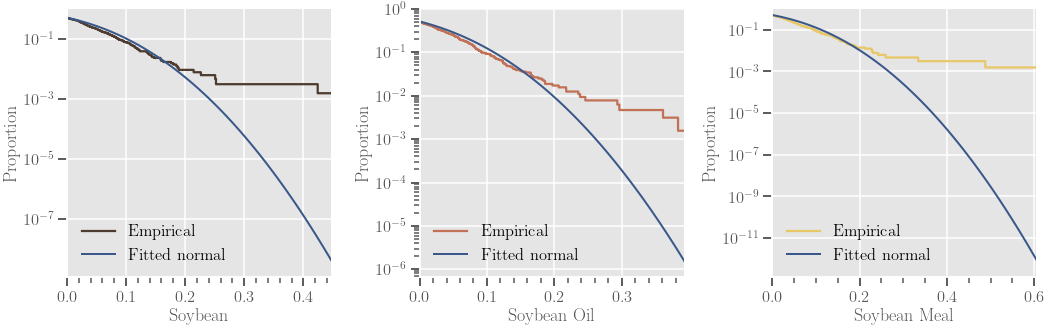

In [64]:
def plot_fit_survival(axes, data):
    xmin, xmax = data.min(), data.max()
    x = np.linspace(xmin, xmax, 100)
    fit = norm.fit(data)
    p = 1 - norm.cdf(x, *fit)
    axes.plot(x, p, color = palette[13], linewidth=2, label='Fitted normal')

fig, ax = plt.subplots(1, 3)
logscale = True

for (axis, asset, col) in zip(ax.ravel(), assets, [0, 1, 2]):
    sns.ecdfplot(logrets_df[asset], ax = axis, complementary=True, label='Empirical', color=palette[col])
    plot_fit_survival(axis, logrets_df[asset])
    axis.set_xlim(0, logrets_df[asset].max()*0.99)
    
    if logscale:
        axis.set_yscale('log')
    else:
        axis.set_ylim(0, 0.5)

    axis.legend()
    
plt.tight_layout()
savefig('TailAnalysis')

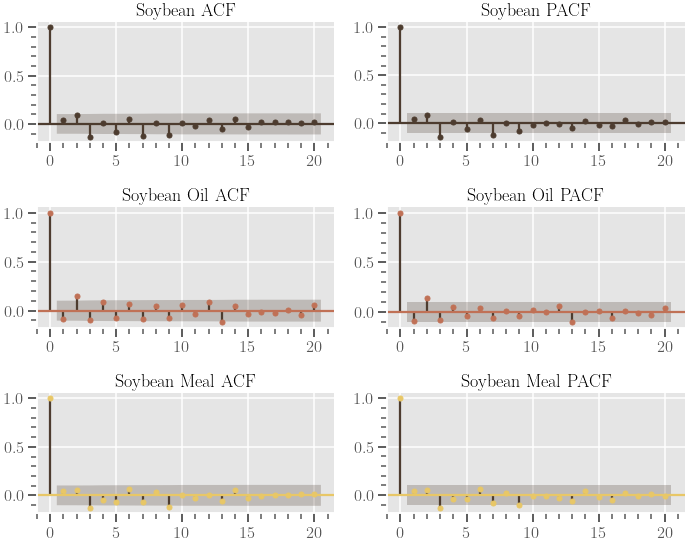

In [61]:
plt.figure(figsize=(10, 8))
zero=True
for ind, (asset, col) in enumerate(zip(assets, [0, 1, 2])):
    ax = plt.subplot(3, 2, 2*ind+1)
    _ = tsaplots.plot_acf(logrets_df[asset], title=f"{asset} ACF",
                          ax = ax, zero=zero, alpha=0.01, lags=20, color=palette[col])
    ax = plt.subplot(3, 2, 2*ind+2)
    _ = tsaplots.plot_pacf(logrets_df[asset], title=f"{asset} PACF",
                           ax = ax, zero=zero, alpha = 0.01, lags=20, color=palette[col])

plt.tight_layout()
savefig("TSA")

In [68]:
def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value', '#Lags Used', 'Number of Observations']
    for value, label in zip(result, labels):
        print(f"{label}: {str(value)}")

    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis indicating it is non-stationary ")

for asset in assets:
    print(f"{asset} logreturns:")
    adfuller_test(logrets_df[asset])
    print("")

Soybean logreturns:
ADF Test Statistic: -10.122409589809182
p-value: 9.369644518334581e-18
#Lags Used: 8
Number of Observations: 631
Reject the null hypothesis. Data is stationary

Soybean Oil logreturns:
ADF Test Statistic: -11.863968879881153
p-value: 6.7435235663140365e-22
#Lags Used: 3
Number of Observations: 636
Reject the null hypothesis. Data is stationary

Soybean Meal logreturns:
ADF Test Statistic: -9.988157489020171
p-value: 2.0293369780951723e-17
#Lags Used: 8
Number of Observations: 631
Reject the null hypothesis. Data is stationary



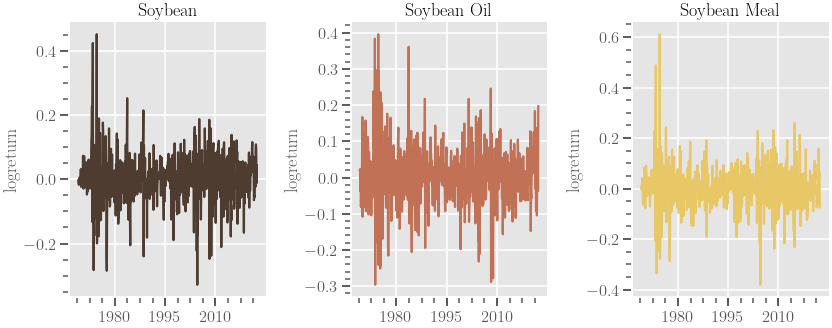

In [77]:
fig, ax = plt.subplots(1, 3)

for i, (asset, col) in enumerate(zip(assets, [0, 1, 2])):
    ax[i].plot(logrets_df.loc[:, asset], label=asset, color=palette[col])
    ax[i].set_title(asset);
    ax[i].set_ylabel('logreturn')
    ax[i].xaxis.set_major_locator(mdates.YearLocator(15))

plt.tight_layout()
savefig('Heteroskedasticity')